In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/My\ Drive/Colab\ Notebooks/Kaggle/df.pkl .

In [0]:
%matplotlib inline

In [0]:
import pickle

import gc
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

### Read processed data 

In [0]:
df = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/Kaggle/df.pkl")

In [0]:
drop_columns = [c for c in df if c[-1] not in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0'] and c.startswith('target')]
drop_columns += ['ID']
features = df.columns.difference(drop_columns)

In [0]:
f0 = df.date_block_num < 34
f1 = df.date_block_num == 34

train, val = train_test_split(df[f0], test_size=0.2, stratify=df[f0]['target'])
test = df[f1]

Train = xgb.DMatrix(train[features], train['target'])
Val = xgb.DMatrix(val[features], val['target'])
Test = xgb.DMatrix(test[features])

In [0]:
del df
gc.collect()

95

### XGBoost Training

In [0]:
%%time

xgb_params = {
    'eval_metric': 'rmse',
    'lambda': '0.171', 
    'gamma': '0.124',
    'booster': 'gbtree', 
    'alpha': '0.170',
    'objective': 'reg:squarederror',
    'colsample_bytree': '0.715',
    'subsample': '0.874', 
    'silent': True,
    'min_child_weight': 26,
    'eta': '0.148',
    'max_depth': 6,
    'tree_method': 'gpu_hist', 
    'n_gpus': 1
}


model = xgb.train(xgb_params, Train, 1500, [(Train, 'Train'), (Val, 'Val')], early_stopping_rounds=10, verbose_eval=1)

[0]	Train-rmse:1.17873	Val-rmse:1.17908
Multiple eval metrics have been passed: 'Val-rmse' will be used for early stopping.

Will train until Val-rmse hasn't improved in 10 rounds.
[1]	Train-rmse:1.12003	Val-rmse:1.12094
[2]	Train-rmse:1.07284	Val-rmse:1.07439
[3]	Train-rmse:1.03822	Val-rmse:1.04006
[4]	Train-rmse:1.01024	Val-rmse:1.01243
[5]	Train-rmse:0.989073	Val-rmse:0.991439
[6]	Train-rmse:0.971939	Val-rmse:0.974767
[7]	Train-rmse:0.95739	Val-rmse:0.960566
[8]	Train-rmse:0.946598	Val-rmse:0.950037
[9]	Train-rmse:0.938954	Val-rmse:0.942515
[10]	Train-rmse:0.932445	Val-rmse:0.936078
[11]	Train-rmse:0.926641	Val-rmse:0.930418
[12]	Train-rmse:0.921827	Val-rmse:0.925975
[13]	Train-rmse:0.917867	Val-rmse:0.922234
[14]	Train-rmse:0.914784	Val-rmse:0.919241
[15]	Train-rmse:0.912124	Val-rmse:0.916812
[16]	Train-rmse:0.909969	Val-rmse:0.914752
[17]	Train-rmse:0.907566	Val-rmse:0.912416
[18]	Train-rmse:0.905673	Val-rmse:0.910674
[19]	Train-rmse:0.903805	Val-rmse:0.908884
[20]	Train-rmse:0.90

### Predict test data

In [0]:
test['item_cnt_month'] = model.predict(Test).clip(0, 20)

### Save submission & model

In [0]:
test[['ID', 'item_cnt_month']].sort_values('ID').to_csv('submission.csv', index=False)
pickle.dump(model, open('xgb.pickle', 'wb'))

### Plot importance feature

In [0]:
model = pickle.load(open('xgb.pickle', 'rb'))

In [0]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax)

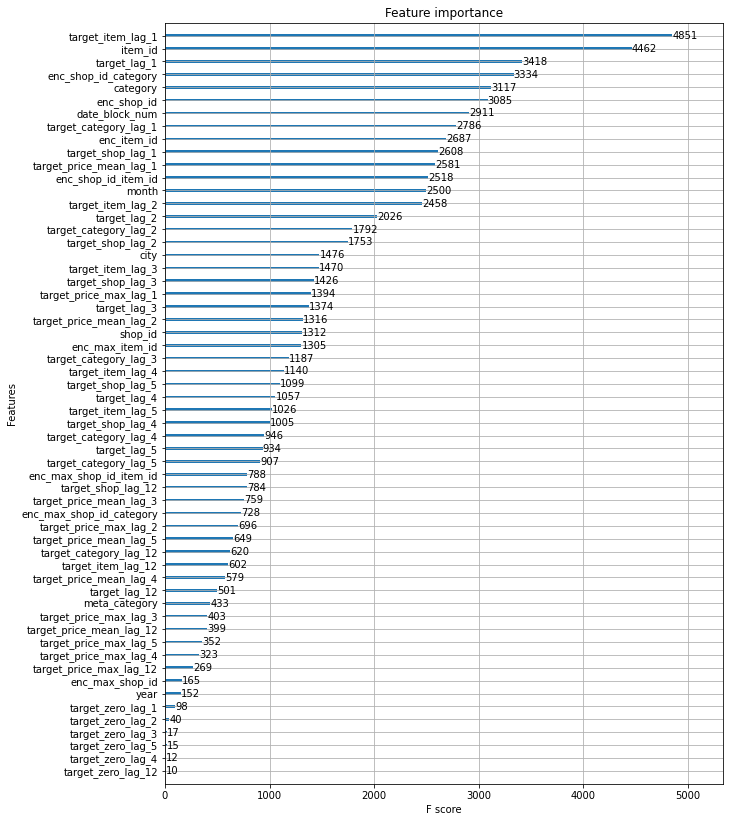

In [0]:
plot_features(model, (10,14))

In [0]:
# Kaggle Submission

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alaydshah","key":"e80169e869dee72bb66fb92e94763010"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission.csv -m "Xgboost_Alay"

100% 3.40M/3.40M [00:01<00:00, 3.51MB/s]
Successfully submitted to Predict Future Sales

In [0]:
!mkdir git

In [0]:
!cp xgb.pickle ./git/

In [0]:
!cp submission.csv git

In [0]:
!cp 